<a href="https://colab.research.google.com/github/oscarserc/TESIS/blob/main/PASO_3d___U_Net____grid20x20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#UTILIZACIÓN DE TÉCNICAS DE APRENDIZAJE AUTOMÁTICO PARA LA DETECCIÓN DE LOS NODOS INFLUYENTES.

La base de datos que emplearemos será de unas 70.000 observaciones. En concreto:

· 72.000 observaciones

· Para ello generamos una 1800 **simulaciones**, y guardamos unos 40 **frames** de cada una de ellas

· Además como **target** guardamos la matriz con la IDENTIDAD de todos y cada uno de los AGENTES.



#**PRUEBA 4**: Utilizaremos una <font color='green'>**Arquitectura de RED NEURONAL U-Net**</font>. Planteamos el problema de localizar a los agentes influyentes como un problema de **Segmentación** de imágenes.

La estructura que hemos probado de partida está basada en el modelo U-Net <font color='blue'> [Ronneberger, O., Fischer, P., & Brox, T. (2015)]</font>, y podemos observarla a continuación.


<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/U_Net_2a.png?raw=true' width="850"/>
<figcaption></figcaption></center>
</figure>



<b>Ref.:</b>

Ronneberger, O., Fischer, P., & Brox, T. (2015, October)  <i>U-Net: Convolutional Networks for Biomedical
Image Segmentation </i>
https://arxiv.org/pdf/1505.04597v1.pdf


<br></br>


El archivo de prueba contiene 4000 simulaciones de una población de AGENTES EMOCIONALES, y otras 4000 de agentes TRAIDORES (de la observación 4001 a la 8000).


<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Archivo_E_CNN.png?raw=true' width="950"/>
<figcaption></figcaption></center>
</figure>



In [ ]:

!pip install wget


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=34ae9b7ed2e2d7c4ff9a110c4ad41a3265116fe23aa91e62db75b49939f18283
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Comenzamos el procesamiento de los datos con la lectura del archivo.

In [ ]:

import wget

# Si usamos el REPOSITORIO para el almacenamiento de datos, creo que hay restricciones de espacio
# si es muy grande el archivo no se puede

# Subimos a los servidores de GOOGLE COOLAB la base de datos de PRUEBA (Acceso en el repositorio: View raw)
# --------------------------------------------------------------------
url_simulaciones = 'https://raw.githubusercontent.com/oscarserc/BASE_de_DATOS/main/bd_combinado.csv'
wget.download(url_simulaciones)


'bd_combinado.csv'

Convertimos en un DATAFRAME y permutamos las filas.

In [ ]:

import pandas as pd

# Cargamos los datos
# ------------------
bd_simulaciones = pd.read_csv('bd_combinado.csv')

# Aleatorizamos
# -------------
bd_simulaciones = bd_simulaciones.sample(frac=1).reset_index(drop=True)



Base de datos con simulaciones en un grid de 20x20 (15% de agentes mutantes traidores).

In [ ]:

import pandas as pd

# CARGAMOS LA BASE DE DATOS SIN PERMUTAR LAS FILAS (grid de 20x20, y población 85-15 emocionales/mutantes)
# ------------------------------------------------
bd_simulaciones = pd.read_csv('bd_100simulaciones_20x20_emo85_vs_15.csv')


#Variables explicativas: **X**

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

size       = 20  # <-------------------------------------------------------------------- CUIDADO, VOY A CAMBIAR EL SIZE A '20'
num_frames = 40
df         = bd_simulaciones.copy()

lista_frames = []
X            = []

nombre_columnas_ROJO  = ['r' + str(indice) for indice in range(size*size)]
nombre_columnas_VERDE = ['g' + str(indice) for indice in range(size*size)]
nombre_columnas_AZUL  = ['b' + str(indice) for indice in range(size*size)]


for fila in range(len(bd_simulaciones)):
  canal_r = pd.array(df[nombre_columnas_ROJO].iloc[fila]).reshape(size,size)
  canal_v = pd.array(df[nombre_columnas_VERDE].iloc[fila]).reshape(size,size)
  canal_a = pd.array(df[nombre_columnas_AZUL].iloc[fila]).reshape(size,size)

  # CUIDADO que np.dstack apila los tres valores de cada pixel
  # ----------------------------------------------------------
  frame = np.array([canal_r, canal_v, canal_a])

  lista_frames.append(frame)

X = np.array(lista_frames)
X.shape



(4000, 3, 20, 20)

#Target: **Y**.

In [ ]:

lista_targets = []

for fila in range(len(bd_simulaciones)):
  lista_id_agentes = bd_simulaciones.iloc[fila]['Target'].replace('[','').replace(']','')
  target = [int(caracter) for caracter in lista_id_agentes.split(',')]
  target = np.array(target)
  target = target.reshape(size,size)

  # Con los paréntesis  '['  ']' sale de dimensión: (8000, 1, 10, 10)   # <-------------------------- Aquí ajusto la DIMENSIÓN
  #lista_targets.append([target])
  # Si queremos de dimensión: (8000, 10, 10)
  lista_targets.append(target)

Y = np.array(lista_targets)
Y.shape



(4000, 20, 20)

#**CONVERSIÓN EN TENSORES DE PyTorch**.

In [ ]:

import numpy as np
import torch

# PRIMERO TENEMOS QUE EXTRAER LA MATRIX:  X
# y los valores del TARGET:               Y
#
# Luego pasaremos (X, Y) al Dataset que creamos a continuación.
# --------------------------------------------------------------

X_train = X
Y_train = Y

# CREAMOS UNA CLASE PARA LOS DATOS
# ================================

class Dataset_frames(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    # self.X = torch.tensor(X).float()
    self.X = torch.tensor(X).float()
    self.Y = torch.tensor(Y).long()

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return self.X[ix], self.Y[ix]


# SELECCIONANDO GRUPOS DE OBSERVACIONES PARA VALIDACIÓN
# -----------------------------------------------------

from sklearn.model_selection import train_test_split

X_subset, X_val, Y_subset, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

dataset = {
    'train' : Dataset_frames(X_subset, Y_subset),
    'val'   : Dataset_frames(X_val, Y_val)
}

dataloader = {
    'train' : torch.utils.data.DataLoader(dataset['train'], batch_size=30,   shuffle=False),
    'val'   : torch.utils.data.DataLoader(dataset['val'],   batch_size=30, shuffle=False)
}


In [ ]:
frames, mascara = next(iter(dataloader['train']))
frames.shape, mascara.shape

(torch.Size([30, 3, 20, 20]), torch.Size([30, 20, 20]))

#**Modelo U-net** (Para la discriminación de 2 clases).

In [ ]:

import torch
import torch.nn.functional as F

# --------------------------------------
# Construimos dos funciones para generar
# módulos para la Red
# --------------------------------------
def conv3x3_bn(canales_in, canales_out):
  return torch.nn.Sequential(
      torch.nn.Conv2d(canales_in, canales_out, 3, padding=1),
      torch.nn.BatchNorm2d(canales_out),
      torch.nn.ReLU(inplace=True)
  )

def encoder_conv(canales_in, canales_out):
  return torch.nn.Sequential(
      torch.nn.MaxPool2d(2),
      conv3x3_bn(canales_in, canales_out),
      conv3x3_bn(canales_out, canales_out)
  )
# ---------------------------------------



# --------------
#  CLASE DECONV
# --------------
class deconv(torch.nn.Module):
  def __init__(self, canales_in, canales_out):
    super(deconv, self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(canales_in, canales_out, 2, stride=2)
    self.conv1    = conv3x3_bn(canales_in, canales_out)
    self.conv2    = conv3x3_bn(canales_out, canales_out)

  # Ahora tenemos que integrar:
  #  · Salida de la capa previa
  #  · Salida del encoder
  def forward(self, x1, x2):
    x1 = self.upsample(x1)
    diffX = x2.size()[2] - x1.size()[2]
    diffY = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, (diffX, 0, diffY, 0))
    # Concatenamos los tensores
    x = torch.cat([x2, x1], dim=1)
    x = self.conv1(x)
    x = self.conv2(x)
    return x


# ============
#  CLASE Unet
# ============
class UNet(torch.nn.Module):
  def __init__(self, n_classes=2, in_ch=3):        # <------------------------------------------------------------------- 2 clases y CREO QUE HAY QUE PONER 3 in
    super().__init__()

    # FILTROS en cada una de las CAPAS que se van a generar
    filtros = [16, 32, 64, 128]

    # PRIMERA CAPA conv
    self.conv1 = torch.nn.Sequential(
        conv3x3_bn(in_ch, filtros[0]),
        conv3x3_bn(filtros[0], filtros[0])
    )

    # Capas del ENCODER
    self.conv2 = encoder_conv(filtros[0], filtros[1])
    self.conv3 = encoder_conv(filtros[1], filtros[2])
    self.conv4 = encoder_conv(filtros[2], filtros[3])

    # Capas del DECODER
    self.deconv1 = deconv(filtros[3], filtros[2])
    self.deconv2 = deconv(filtros[2], filtros[1])
    self.deconv3 = deconv(filtros[1], filtros[0])

    # ULTIMA CAPA CONV --> Nos da la MÁSCARA
    self.out = torch.nn.Conv2d(filtros[0], n_classes, 3, padding=1)

  def forward(self, x):
    # ENCODER
    x1 = self.conv1(x)
    x2 = self.conv2(x1)
    x3 = self.conv3(x2)
    x  = self.conv4(x3)

    # DECODER
    x = self.deconv1(x, x3)
    x = self.deconv2(x, x2)
    x = self.deconv3(x, x1)
    x = self.out(x)
    return x



In [ ]:

modelo_UNet = UNet()
salida = modelo_UNet(torch.randn((10, 3, 394, 394)))
salida.shape


torch.Size([10, 2, 394, 394])

#**MÉTODO para el ENTRENAMIENTO**.

In [ ]:

from sklearn.metrics import accuracy_score

# Función auxiliar
# ----------------

def softmax(x):
  return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)



# DEFINIMOS LA FUNCIÓN DE ENTRENAMIENTO
# =====================================

def fit(model, dataloader, epochs=10, log_each=1):
   criterion = torch.nn.CrossEntropyLoss()
   optimizer = torch.optim.SGD(model.parameters(), lr=0.8)

   l, acc         = [], []
   val_l, val_acc = [], []

   for e in range(1, epochs+1):
      _l, _acc = [], []
      model.train()  # <------------------------------------------ MODO de ENTRENAMIENTO
      for x_b, y_b in dataloader['train']:
        y_pred = model(x_b)
        loss   = criterion(y_pred, y_b)
        _l.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_probas = torch.argmax(softmax(y_pred), axis=1)
        # Los SCORES de SKLEARN no aceptan matrices, así que hay que convertirlas en dimensión 1D (usar flatten())
        _acc.append(accuracy_score(y_b.numpy().flatten(), y_probas.detach().numpy().flatten()))

      l.append(np.mean(_l))
      acc.append(np.mean(_acc))
      if not e % log_each:
        print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f}")


      model.eval()  # <------------------------------------------- MODO de EVALUACIÓN
      _l, _acc = [], []
      with torch.no_grad():
        for x_b, y_b in dataloader['val']:
          y_pred = model(x_b)
          loss   = criterion(y_pred, y_b)
          _l.append(loss.item())
          y_probas = torch.argmax(softmax(y_pred), axis=1)
          _acc.append(accuracy_score(y_b.numpy().flatten(), y_probas.numpy().flatten()))
      val_l.append(np.mean(_l))
      val_acc.append(np.mean(_acc))

   return {'epoch':list(range(1,epochs+1)), 'loss':l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}



#**ENTRENAMIENTO DEL MODELO**.

In [ ]:

# INSTANCIAMOS EL MODELO
# ======================

# Imprimimos junto al número de Epoch, el valor de la función de pérdida y la accuracy (Supera el 98%)
model  = UNet()
hist   = fit(model, dataloader, 20)


Epoch 1/20 loss 0.03038 acc 0.95178
Epoch 2/20 loss 0.00152 acc 0.97992
Epoch 3/20 loss 0.00082 acc 0.98048
Epoch 4/20 loss 0.00055 acc 0.98060
Epoch 5/20 loss 0.00040 acc 0.98070
Epoch 6/20 loss 0.00030 acc 0.98073
Epoch 7/20 loss 0.00023 acc 0.98075
Epoch 8/20 loss 0.00019 acc 0.98081
Epoch 9/20 loss 0.00015 acc 0.98081
Epoch 10/20 loss 0.00013 acc 0.98081
Epoch 11/20 loss 0.00011 acc 0.98084
Epoch 12/20 loss 0.00010 acc 0.98083
Epoch 13/20 loss 0.00008 acc 0.98085
Epoch 14/20 loss 0.00008 acc 0.98085
Epoch 15/20 loss 0.00007 acc 0.98085
Epoch 16/20 loss 0.00006 acc 0.98086
Epoch 17/20 loss 0.00006 acc 0.98085
Epoch 18/20 loss 0.00005 acc 0.98085
Epoch 19/20 loss 0.00005 acc 0.98086
Epoch 20/20 loss 0.00005 acc 0.98087


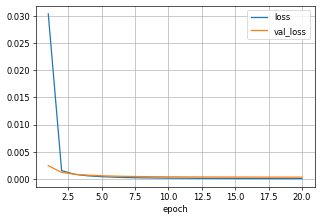

In [ ]:

# GRAFICAMOS LOS RESULTADOS DEL APRENDIZAJE
# =========================================

import matplotlib.pyplot as plt

fig = plt.figure(dpi=60)
#fig = plt.figure(figsize=(10,6))
ax  = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', y=['loss','val_loss'], grid=True, ax=ax)
#lt.ylim([0,0.010])
plt.show()


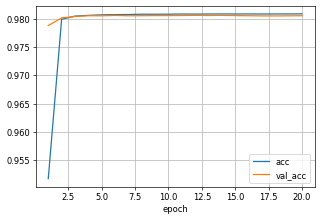

In [ ]:

# GRAFICAMOS LOS RESULTADOS DEL APRENDIZAJE
# =========================================

import matplotlib.pyplot as plt

fig = plt.figure(dpi=60)
#fig = plt.figure(figsize=(10,6))
ax  = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', y=['acc','val_acc'], grid=True, ax=ax)
#lt.ylim([0,0.010])
plt.show()


#Probamos con una simulación concreta para inspeccionarla.

In [ ]:

from sklearn.metrics import confusion_matrix

torch.set_printoptions(precision=2)

X_prueba, y_prueba = next(iter(dataloader['val']))
y_prediccion = model(X_prueba)

y_prob = torch.argmax(softmax(y_prediccion), axis=1)
y_prob[1]


tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0,

In [ ]:

confusion_matrix(y_prueba[1].flatten().numpy(), y_prob[1].flatten().numpy())


array([[320,  11],
       [  0,  69]])

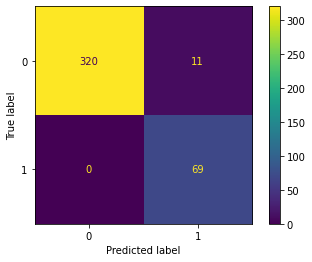

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay

# Agente emocional         --> código: 0
# Agente mutante (traidor) --> código: 1
# --------------------------------------
ConfusionMatrixDisplay.from_predictions(y_prueba[1].flatten().numpy(), y_prob[1].flatten().numpy())


#Ahora probamos con todos los datos de VALIDACIÓN.

In [ ]:

from functools import reduce

predicciones  = []
observaciones = []

# Iteramos por el conjunto de datos de Validación
# -----------------------------------------------
for x_b, y_b in dataloader['val']:
  y_pred = model(x_b)
  y_prob = torch.argmax(softmax(y_pred), axis=1)
  # Se añaden como arrays a la lista, por lo que convertimos previamente a una lista
  # El resultado es una lista de lista, por lo que las reducimos a una sola más abajo
  # (Esto es así porque el procedimiento confusion_matrix sólo opera datos de 1 dimensión)
  predicciones.append(list(y_prob.numpy().flatten()))
  observaciones.append(list(y_b.numpy().flatten()))

data_pred = reduce(lambda a, b: a+b, predicciones)
data_obs  = reduce(lambda a, b: a+b, observaciones)

confusion_matrix(data_obs, data_pred)



array([[265294,   6228],
       [     3,  48475]])

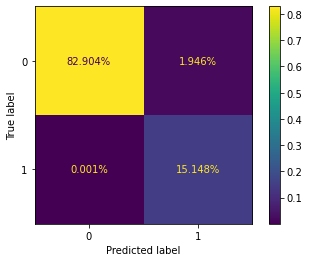

In [ ]:

ConfusionMatrixDisplay.from_predictions(data_obs, data_pred, normalize='all', values_format='.3%')


#Inspeccionamos más detenidamente el tipo de fallos que ocurren en una animación concreta.

In [ ]:

from sklearn.metrics import confusion_matrix

torch.set_printoptions(precision=2)

X_obs, y_obs = next(iter(dataloader['val']))
y_probab = model(X_obs)
y_predic = torch.argmax(softmax(y_probab), axis=1)

# Utilizamos códigos para representar los colores y así identificar
# mejor a los agentes en la predicción (agentes MUTANTES)
red    = '\033[91m'
green  = '\033[92m'
black  = '\x1b[0m'

frame  = 1
cadena = ''
size_m = 3

for i in range(size):
  for j in range(size):
    if (y_predic[frame,i,j] != y_obs[frame,i,j]) and (y_predic[frame,i,j] == 1):
      cadena += red + str(y_predic[frame,i,j].numpy()) + black + '  '
    elif (y_predic[frame,i,j] != y_obs[frame,i,j]) and (y_predic[frame,i,j] == 0):
      cadena += red + '.' + black + '  '
    elif (y_predic[frame,i,j] == y_obs[frame,i,j]) and (y_predic[frame,i,j] == 1):
      cadena += green + str(y_predic[frame,i,j].numpy()) + black + '  '
    else:
      cadena += str(y_predic[frame,i,j].numpy()) + '  '
  cadena += '\n'

print(cadena)



0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  1  1  0  1  0  
0  0  1  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  1  0  
0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  
0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  
0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  
0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  
0  0  1  0  0  0  0  0  1  1  0  0  0  0  0  0  0  1  0  0  
0  0  0  0  1  0  1  0  0  0  0  0  1  0  1  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  
0  0  0  0  0  1  0  1  0  0  0  0  1  0  1  0  0  1  0  1  
0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  1  0  0  0  
0  0  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  
1  0  0  0  0  0  0  1  1  1  1  1  1  0  1  1  1  0  1  0  
0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  
0  0  1  0  1  1  0  0  0  1  0  0  1  0  0  0  0  0  0  1  
0  1  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  1  0  
0  0  0  0  0  1  0  0  

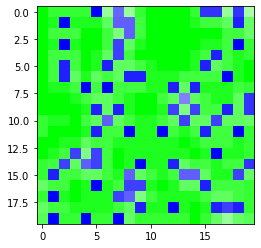

In [ ]:

import matplotlib.pyplot as plt

# Uno de los frames
# -----------------
plt.imshow(X_obs[1].permute(1,2,0))
plt.show()


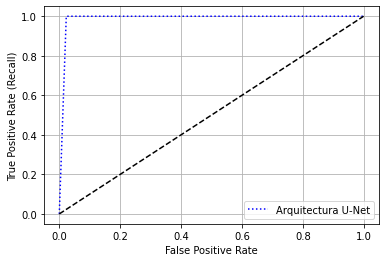

In [ ]:

from sklearn.metrics import roc_curve

# CURVA ROC  (Creo que son 'scores' lo que se le debe pasar
# como segundo argumento. No sé si se puede hacer así)
# ---------------------------------------------------------
fpr, tpr, thresholds = roc_curve(data_obs, data_pred)
plt.plot(fpr, tpr, 'b:', label='Arquitectura U-Net')
plt.plot([0, 1], [0, 1], 'k--')
#plt.axis([0, 1, 0, 1])     # Libro de Aurelien Geron
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()
